<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-и-предобработка-данных" data-toc-modified-id="Анализ-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ и предобработка данных</a></span></li><li><span><a href="#Обучение-моделей-и-расчет-целевой-метрики-качества" data-toc-modified-id="Обучение-моделей-и-расчет-целевой-метрики-качества-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей и расчет целевой метрики качества</a></span><ul class="toc-item"><li><span><a href="#Техника-TF-IDF" data-toc-modified-id="Техника-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Техника TF-IDF</a></span></li><li><span><a href="#Модель-по-алгоритму-LogisticRegression" data-toc-modified-id="Модель-по-алгоритму-LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель по алгоритму LogisticRegression</a></span></li><li><span><a href="#Модель-по-алгоритму-LinearSVC" data-toc-modified-id="Модель-по-алгоритму-LinearSVC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель по алгоритму LinearSVC</a></span></li><li><span><a href="#Модель-по-алгоритму-LGBMClassifier" data-toc-modified-id="Модель-по-алгоритму-LGBMClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель по алгоритму LGBMClassifier</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Техника-BERT" data-toc-modified-id="Техника-BERT-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Техника BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Метрика качества *F1* должна быть не меньше 0.75. 

## Анализ и предобработка данных

Установим необходимые библиотеки:

In [1]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 1.3 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Импортируем библиотеки:

In [2]:
import re
import torch
import transformers
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier

SEED=777

In [3]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим датасет и сохраним в переменной:

In [4]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

Выведем 5 случайных строк датасета:

In [5]:
toxic_comments.sample(5)

,text,toxic
50917,"Hi there, in response to your question above, ...",0
11727,Hello. I am on a public computer where there h...,0
104476,I'm confused. My plea for help was ignored abo...,0
88677,She should throw away the glasses and let her ...,0
152435,.sO YOU BITCH NIGGAS MUST NOT SAY SHIT.......Y...,1


Тексты на английском языке, их необходимо будет очистить от стоп-слов, а отдельные слова привести к начальной словарной форме (лемме).

Посмотрим общую информацию о датасете:

In [6]:
toxic_comments.info()
toxic_comments.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Пропусков в данных нет, типы данных соответсвуют ожидаемым.

Проверим наличие явных дубликатов:

In [7]:
toxic_comments.duplicated().sum()

0

В датасете нет явных дубликатов. 

Проверим баланс классов:

In [8]:
toxic_comments['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

В данных присутствует сильный дисбаланс классов, это надо будет учесть при разделении датасета на обучающую и тестовую выборки.

Проведем предобработку текстов - токенизацию и лемматизацию, для этого создадим функцию:

In [9]:
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
def func_lemm_text(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    text = ' '.join(text.lower().split())
    doc = lemmatizer(text)
    clear_text = " ".join([token.lemma_ for token in doc if token.lemma_ not in stopwords])
    return clear_text

In [11]:
toxic_comments['clear_text'] = toxic_comments['text'].progress_apply(lambda x: func_lemm_text(x))
toxic_comments.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour I seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I really try edit war guy constantly r...
3,"""\nMore\nI can't make any real suggestions on ...",0,I make real suggestion improvement I wonder se...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Разделим датасет на обучающую и тестовую выборки (чтобы выборка была более репрезентативной при разбиении будем использовать параметр stratify):

In [12]:
X, y = toxic_comments.drop(['text', 'toxic'], axis=1), toxic_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

In [13]:
print('Размеры получившихся выборок:\n '
      'Признаки, обучающая выборка:', X_train.shape, '\n',
      'Признаки, тестовая выборка:', X_test.shape, '\n',
      'Целевой признак, обучающая выборка:', y_train.shape, '\n',
      'Целевой признак, тестовая выборка:', y_test.shape, '\n')

Размеры получившихся выборок:
 Признаки, обучающая выборка: (111504, 1) 
 Признаки, тестовая выборка: (47788, 1) 
 Целевой признак, обучающая выборка: (111504,) 
 Целевой признак, тестовая выборка: (47788,) 



## Обучение моделей и расчет целевой метрики качества

### Техника TF-IDF

Создадим новые признаки с помощью техники TF-IDF:

In [14]:
count_tf_idf = TfidfVectorizer(lowercase=True)
X_train_tf_idf = count_tf_idf.fit_transform(X_train['clear_text'])
X_test_tf_idf = count_tf_idf.transform(X_test['clear_text']) # transform(), чтобы не было утечки тестовых данных

Далее обучим и рассчитаем метрики качества на моделях, построенных по следующим алгоритмам:
- логистической регрессии LogisticRegression;
- линейной классификации методом опорных векторов LinearSVC;
- градиентного бустинга LGBMClassifier.

### Модель по алгоритму LogisticRegression

Подберем гиперпараметры модели, построенной по алгоритму логистической регрессии LogisticRegression, используя GridSearchCV. Для того чтобы не было утечки данных из тестовых фолдов при кросс-валидации, используем Pipeline:

In [15]:
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=SEED, class_weight = 'balanced')),
])

lr_params = [{
    #'tfidf__max_df': (0.71, 0.85, 0.99),
    #'tfidf__max_features': (None, 5000, 10000, 50000),
    #'tfidf__ngram_range': ((1, 1), (1, 2), (1,3)), 
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2', None),
    'lr__solver': ('saga',), #saga для больших датасетов
    #'lr__penalty': ('l1', 'l2'),
    'lr__C': (1.0, 10),
    'lr__tol': (0.0001, 0.001)
}]

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=lr_params, cv=3, scoring='f1', n_jobs=-1)

Обучим модель:

In [16]:
%%time
lr_grid.fit(X_train['clear_text'], y_train)
#Wall time: 1min 49s

CPU times: user 2min 2s, sys: 377 ms, total: 2min 3s
Wall time: 2min 3s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=777))]),
             n_jobs=-1,
             param_grid=[{'lr__C': (1.0, 10), 'lr__solver': ('saga',),
                          'lr__tol': (0.0001, 0.001)}],
             scoring='f1')

Найдем гиперпараметры лучшей модели:

In [17]:
lr_grid.best_params_

{'lr__C': 10, 'lr__solver': 'saga', 'lr__tol': 0.0001}

Найдем метрику качества f1-мера модели с наилучшими гиперпараметрами:

In [18]:
lr_grid.best_score_

0.7652034184514843

Таким образом, метрика качества f1-мера для модели, построенной по алгоритму LogisticRegression, на тренировочный выборке получилась равной 0.7652.

### Модель по алгоритму LinearSVC

Аналогичный pipeline создадим для модели, построенной по алгоритму линейной классификации методом опорных векторов LinearSVC:

In [19]:
lsvc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsvc', LinearSVC(random_state=SEED, class_weight = 'balanced')),
])

lsvc_params = [{
    #'lsvc__penalty': ('l1', 'l2'),
    'lsvc__C': (1.0, 10.0),
    'lsvc__tol': (0.0001, 0.001, 0.01),
    'lsvc__max_iter': range(70, 120, 10)
}]

lsvc_grid = GridSearchCV(estimator=lsvc_pipe, param_grid=lsvc_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)

Обучим модель:

In [20]:
%%time
lsvc_grid.fit(X_train['clear_text'], y_train)
# Wall time: 5min 55s

CPU times: user 6min 30s, sys: 1.99 s, total: 6min 32s
Wall time: 6min 32s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lsvc',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=777))]),
             n_jobs=-1,
             param_grid=[{'lsvc__C': (1.0, 10.0),
                          'lsvc__max_iter': range(70, 120, 10),
                          'lsvc__tol': (0.0001, 0.001, 0.01)}],
             scoring='f1')

Найдем гиперпараметры лучшей модели:

In [21]:
lsvc_grid.best_params_

{'lsvc__C': 1.0, 'lsvc__max_iter': 70, 'lsvc__tol': 0.0001}

Найдем метрику качества f1-мера модели с наилучшими гиперпараметрами:

In [22]:
lsvc_grid.best_score_

0.758761280264963

Таким образом, метрика качества f1-мера для модели, построенной по алгоритму LinearSVC, на тренировочный выборке получилась равной 0.7588.

### Модель по алгоритму LGBMClassifier

Аналогичный pipeline сделаем для градиентного бустинга LGBMClassifier:

In [23]:
lgbm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgbm', LGBMClassifier(random_state=SEED, class_weight = 'balanced')),
])

lgbm_params = {
    'lgbm__n_estimators': (100, 200),
    #'lgbm__learning_rate': (0.1, 1.0),
    #'lgbm__max_depth': (-1, 5, 10),
    'lgbm__num_leaves': (11, 21, 31)
}

lgbm_grid = GridSearchCV(estimator=lgbm_pipe, param_grid=lgbm_params, cv=3, scoring='f1', n_jobs=-1, verbose=0)

Обучим модель:

In [24]:
%%time
lgbm_grid.fit(X_train['clear_text'], y_train)
# Wall time: Wall time: 22min 29s

CPU times: user 28min 56s, sys: 7.05 s, total: 29min 3s
Wall time: 29min 10s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lgbm',
                                        LGBMClassifier(class_weight='balanced',
                                                       random_state=777))]),
             n_jobs=-1,
             param_grid={'lgbm__n_estimators': (100, 200),
                         'lgbm__num_leaves': (11, 21, 31)},
             scoring='f1')

Найдем гиперпараметры лучшей модели:

In [25]:
lgbm_grid.best_params_

{'lgbm__n_estimators': 200, 'lgbm__num_leaves': 31}

Рассчитаем метрику качества f1-мера модели с наилучшими гиперпараметрами:

In [26]:
lgbm_grid.best_score_

0.750058561464133

Таким образом, метрика качества f1-мера для модели, построенной по алгоритму LGBMClassifier, на тренировочный выборке получилась равной 0.7652.

## Анализ моделей

Представим итоговый результат и сравним получившиеся метрики качества моделей.  
Сохраним получившиеся наилучшие метрики по каждой модели в соответствующих переменных:

In [27]:
lr_grid_score = lr_grid.best_score_
lr_grid_score

0.7652034184514843

In [28]:
lsvc_grid_score = lsvc_grid.best_score_
lsvc_grid_score

0.758761280264963

In [29]:
lgbm_grid_score = lgbm_grid.best_score_
lgbm_grid_score

0.750058561464133

Результат сохраним в датафрейм:

In [30]:
f1_metrics_df = pd.DataFrame(
    data=[lr_grid_score, lsvc_grid_score, lgbm_grid_score],
    index=['LogisticRegression', 'LinearSVC', 'LightGBM'],
    columns=['f1_train']
)
f1_metrics_df.sort_values('f1_train').style.background_gradient(subset=['f1_train'], cmap='Greens')

,f1_train
LightGBM,0.750059
LinearSVC,0.758761
LogisticRegression,0.765203


Таким образом, по метрике f1-мера наилучшей моделью оказалась модель, обученная по алгоритму LogisticRegression, с результатом 0.765203.

Найдем метрику f1-мера лучшей модели (по алгоритму LogisticRegression) на тестовой выборке:

In [31]:
lr_grid.best_params_ #параметры наилучшей модели, полученной на тренировочной выборке

{'lr__C': 10, 'lr__solver': 'saga', 'lr__tol': 0.0001}

In [32]:
%%time
lr_best_params = {'C': 10, 'solver': 'saga', 'tol': 0.0001}

best_model = LogisticRegression(
    random_state=SEED, 
    class_weight='balanced'
).set_params(**lr_best_params)

best_model.fit(X_train_tf_idf, y_train)
#Wall time: 11.2 s

CPU times: user 9.28 s, sys: 20.2 ms, total: 9.3 s
Wall time: 9.3 s


LogisticRegression(C=10, class_weight='balanced', random_state=777,
                   solver='saga')

Рассчитаем метрику качества f1-мера на тестовой выборке:

In [33]:
y_pred = best_model.predict(X_test_tf_idf)
f1_best_model = f1_score(y_test, y_pred)
print('Метрика качества f1-мера лучшей модели: {:.4f}'.format(f1_best_model))

Метрика качества f1-мера лучшей модели: 0.7584


Полученное значение метрики f1-мера на тестовой выборке получилось равным 0.7584, что больше 0.75, а значит полученная модель удовлетворяет исходным требованиям к проекту.

Создадим матрицу ошибок предсказаний данной модели:

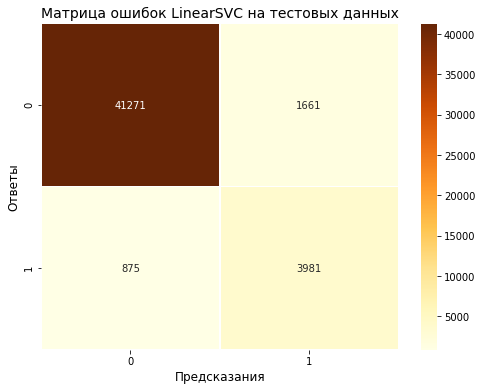

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=.5, annot=True, fmt='d', cmap='YlOrBr')
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.title('Матрица ошибок LinearSVC на тестовых данных', fontsize=14)
plt.show()

Согласно полученной матрице, общее число ошибок равно 2536. Большая часть из этих ошибок - это неправильно размеченные негативные комментарии - 1661.

## Техника BERT

Попробуем улучшить качество модели, заменив технику TF-IDF на BERT. Но в силу некоторых технических ограничений, связанных с BERT, ограничим длину текстов 128 символами и возьмем небольшую выборку из 3000 текстов. Загрузим предобученную модели toxic-bert и токенизатор:

In [35]:
# Модель toxic-bert
model_class, tokenizer_class, pretrained_weights = (
    transformers.BertModel, transformers.BertTokenizer, 'unitary/toxic-bert'
)

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Как было оговорено выше, возьмем для проверки только 3000 текстов и ограничим длину текстов 128 символами:

In [36]:
toxic_comments_bert = toxic_comments.query('toxic==1').sample(200).append(toxic_comments.query('toxic==0').sample(1800)).sample(frac=1)
toxic_comments_bert['text'] = toxic_comments_bert['text'].str[:128]

In [37]:
tokenized = toxic_comments_bert['text'].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  0%|          | 0/2000 [00:00<?, ?it/s]

Приведем векторы признаков к одному размеру путем добавления нулей к более коротким векторам

In [38]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Поскольку эти нули не несут значимой информации, отбросим эти токены и «создадим маску» для действительно важных токенов:

In [39]:
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(2000, 69)


Создадим эмбеддинги для текстов, ограничив размер батча 50 объектами:

In [40]:
batch_size = 50
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████| 40/40 [07:38<00:00, 11.46s/it]


Запишем все эмбеддинги в матрицу признаков, выделим целевой признак и разделим данные на выборки:

In [41]:
X_bert = np.concatenate(embeddings)
y_bert = toxic_comments_bert['toxic']

In [42]:
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(
    X_bert, y_bert, test_size = 0.3, random_state=SEED, stratify=y_bert
)

In [43]:
%%time
model_lr_bert = best_model
model_lr_bert.fit(X_bert_train, y_bert_train)
y_pred_bert = model_lr_bert.predict(X_bert_test)
f1_model_lr_bert = f1_score(y_bert_test, y_pred_bert)
print('Метрика качества f1-мера лучшей модели: {:.4f}'.format(f1_model_lr_bert))
#2 Метрика качества f1-мера лучшей модели: 0.8235
#1 Метрика качества f1-мера лучшей модели: 0.8000

Метрика качества f1-мера лучшей модели: 0.8065
CPU times: user 1.24 s, sys: 247 µs, total: 1.24 s
Wall time: 1.23 s


Модель, построенная по алгоритму LogisticRegression совместно с моделью toxic-bert, показала результат лучше (0.8065 на тесте), чем модель с TF-IDF, даже несмотря на большие ограничения, наложенные при создании признаков техникой BERT. Таким образом, модель, построенная по алгоритму LogisticRegression совместно с моделью toxic-bert, является лучшей.

## Выводы

В рамках данного проекта необходимо было разработать модель для классифицикации комментарией на позитивные и негативные. В качестве оценки качества необходимой модели выбрана f1-мера, и качество итоговой модели по этой метрике должно быть не менее 0.75.
На первом этапе была проведена предобработка данных - токенизация и лемматизация корпуса текстов, также были созданы признаки с помощью техники TF-IDF.

Далее были обучены и рассчитаны метрики качества на моделях, построенных по следующим алгоритмам:
- логистической регрессии LogisticRegression;
- линейной классификации методом опорных векторов LinearSVC;
- градиентного бустинга CatBoostClassifier.

В результате наилучший результат на тестовой выборке по метрике качества f1-мера, равной 0.774, получился у модели, построенной по алгоритму линейной классификации методом опорных векторов LinearSVC. Полученное значение метрики качества больше 0.75, что удовлетворяет исходным требованиям к проекту. 

Также была предпринята попытка улучшить качество модели, заменив технику TF-IDF на BERT (с моделью toxic-bert). Несмотря на серьезные ограничения, наложенные при создании признаков техникой BERT, модель, построенная по алгоритму LogisticRegression совместно с моделью toxic-bert, оказалась лучшей моделью с результатом 0.8065 по метрике качества f1-мера.